In [1]:
import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as prop
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
#from __future__ import division

plt.rc('text',usetex = True)
plt.rc('font', family='serif')

Dados de entrada

In [2]:
V_a = 50/3600  #Vazao volumetrica de ar na entrada
m_b = 2.8/3600 #Vazao massica de refrigerante na entrada na entrada

T_a_in = -15+273.15    #Temperatura do ar na entrada
p_b_in = 78500 # Pressao do refrigerante na entrada
x_b_in = 0.43  # Titulo do refrigerante na entrada

Dados geometricos de entrada

In [3]:
W = 0.3  # Comprimento do envelopeo
L = 0.19 # Altura do envelope
H = 0.06 # Espessura do envelope


A_f_b = 53.2*10**-2   # Area das aletas grandes
A_f_s = 49.4*10**-2   # Area das aletas pequenas

d_e = 7.9*10**-3      # Diametro externo dos tubos
d_i = 6.7*10**-3      # Diametro interno dos tubos 
L_s = 7.8             # Comprimento da serpentina

X_l = 19*10**-3       # Espacamento transversal das aletas
X_t = 11*10**-3       # Espacamento longitudinal das aletas

sigma_f = 0.15*10**-3 # Espessura das aletas

Calculos geometricos - Primeira Zona

In [4]:
nf_1 = 23
nt_1 = 6

T_1 = 3*X_l

A_p_1 = np.pi*d_e*(W-nf_1*sigma_f)*nt_1+2*(T_1*H - np.pi*(d_e**2)/4*nt_1)
A_s_1 = 2*(T_1*H - np.pi*(d_e**2)/4*nt_1)*(nf_1+1)+H*sigma_f*nf_1
A_t_1 = A_p_1 + A_s_1

a_1 = (X_t-d_e) - (X_t-d_e)*(sigma_f)*nf_1/W
b_1 = ((X_t/2)**2+X_l**2)**(0.5) - d_e -(X_t-d_e)*sigma_f*nf_1/W

c_1 = min(a_1,2*b_1)

A_c_1 = (H/X_t-1)*c_1*W+(X_t-d_e)*W -(X_t - d_e)*sigma_f*nf_1 

Calculos geometricos - Segunda Zona

In [5]:
nf_2 = 47
nt_2 = 6
T_2 = 3*X_l
A_p_2 = np.pi*d_e*(W-nf_2*sigma_f)*nt_2+2*(T_2*H - np.pi*d_e**2/4*nt_2)
A_s_2 = 2*(T_2*H - np.pi*d_e**2/4*nt_2)*(nf_2+1)
A_t_2 = A_p_2+A_s_2

a_2 = (X_t - d_e) - (X_t-d_e)*sigma_f*nf_2/W
b_2 = ((X_t/2)**2+X_l**2)**(1/2) - d_e - (X_t-d_e)*sigma_f*nf_2/W

c_2 = min(a_2,2*b_2)

A_c_2 = (H/X_t-1)*c_2*W+(X_t-d_e)*W -(X_t - d_e)*sigma_f*nf_2

Calculos geometricos - Terceira Zona

In [6]:
nf_3 = 47
nt_3 = 8
T_3 = 4*X_l
A_p_3 = np.pi*d_e*(W-nf_3*sigma_f)*nt_3+2*(T_3*H - np.pi*d_e**2/4*nt_3)
A_s_3 = 2*(T_3*H - np.pi*d_e**2/4*nt_3)*(nf_3+1)+H*sigma_f*nf_3
A_t_3 = A_p_3+A_s_3

a_3 = (X_t - d_e) - (X_t-d_e)*sigma_f*nf_3/W
b_3 = ((X_t/2)**2+X_l**2)**(1/2) - d_e - (X_t-d_e)*sigma_f*nf_3/W

c_3 = min(a_3,2*b_3)

A_c_3 = (H/X_t-1)*c_3*W+(X_t-d_e)*W -(X_t - d_e)*sigma_f*nf_3

In [7]:
A_p=np.zeros((10,2))
A_s=np.zeros((10,2))
A_t=np.zeros((10,2))
A_c=np.zeros((10,2))

A_p[0:4,:]=A_p_1
A_p[4:7,:]=A_p_2
A_p[7:10,:]=A_p_3

A_s[0:4,:]=A_s_1
A_s[4:7,:]=A_s_2
A_s[7:10,:]=A_s_3

A_c[0:4,:]=A_c_1
A_c[4:7,:]=A_c_2
A_c[7:10,:]=A_c_3

A_t[0:4,:]=A_t_1
A_t[4:7,:]=A_t_2
A_t[7:10,:]=A_t_3

Relacoes Empiricas ar

In [18]:
def h_a(V_a,A_c,T,phi):
    rho = prop.PropsSI('D','P',100000,'T',T+273.15,'Air')
    mu = prop.PropsSI('V','P',100000,'T',T+273.15,'Air')
    Pr = prop.PropsSI('PRANDTL','P',100000,'T',T+273.15,'Air')
    cp  = prop.PropsSI('C','P',100000,'T',T+273.15,'Air')
    
    G = V_a*rho/A_c
    Re = G*d_e/mu
    #j = 0.138*Re**(-0.281)*phi**(-0.407)
    j =  0.6976*Re**(-0.4842)*phi**(-0.3426)
    St = j*Pr**(2/3)
    h = St*G*cp
    return h

In [19]:
def fd(Re):
    A = (2.457*np.log(1/(7/Re)**0.9))**16
    B = (37530/Re)**16
    f = 8*((8/Re)**12+(A+B)**(-3/2))**(1/12)
    return f

In [20]:
def dpz(x,p,d_i,m_b):
    rho_l = prop.PropsSI('D','P',p,'Q',0,'R134a')
    rho_v = prop.PropsSI('D','P',p,'Q',1,'R134a')
    
    mu_l = prop.PropsSI('V','P',p,'Q',0,'R134a')
    mu_v = prop.PropsSI('V','P',p,'Q',1,'R134a')
    
    G = m_b/(np.pi*d_i**2/4)
    
    Re_lo = G*(1-x)*d_i/mu_l
    Re_vo = G*x*d_i/mu_l
    
    f_lo = fd(Re_lo)
    f_vo = fd(Re_lo)
    
    dp_lo = f_lo*G**2/(2*d_i*rho_l)
    dp_vo = f_vo*G**2/(2*d_i*rho_v)
    
    A = dp_lo + 2*(dp_vo-dp_lo)*x
    dp = A*(1-x)**(1/3)+dp_vo*x**3
    
    return dp

In [21]:
def bif(x,p,d_i,m_b):
    rho_l = prop.PropsSI('D','P',p,'Q',0,'R134a')
    rho_v = prop.PropsSI('D','P',p,'Q',1,'R134a')
    
    mu_l = prop.PropsSI('V','P',p,'Q',0,'R134a')
    mu_v = prop.PropsSI('V','P',p,'Q',1,'R134a') 
    
    Pr = prop.PropsSI('PRANDTL','P',p,'Q',0,'R134a')
    k = prop.PropsSI('L','P',p,'Q',0,'R134a')
    
    Xtt = (((1-x)/x)**0.9)*((rho_v/rho_l)**0.5)*((mu_l/mu_v)**0.1)
    
    G = m_b/(np.pi*d_i**2/4)
    h_DB = (k/d_i)*0.023*(G*d_i/mu_l)**0.8*Pr**0.4
    h    = h_DB*3.775*Xtt**(-0.6285)
    
    mu_h = ((1-x)/mu_l + x/mu_v)**-1
    Re_h = G*d_i/mu_h
    
    f = fd(Re_h)
    
    return h,f

In [22]:
def mon(p,T,d_i,m_b):

    mu = prop.PropsSI('V','P',p,'T',T,'R134a')
    Pr = prop.PropsSI('PRANDTL','T',T,'Q',0,'R134a')
    k = prop.PropsSI('L','P',p,'T',T,'R134a')
    
    G = m_b/(np.pi*d_i**2/4)
    h = (k/d_i)*0.023*(G*d_i/mu)**0.8*Pr**0.4
    
    Re = G*d_i/mu
    f = fd(Re)
    
    return (h,f)

Definicoes numericas

In [23]:
N_L = 5000
N_H = 1
N_W = 2

dx = (10*L)/N_L
dy = H/N_H
dz = W/N_W

In [24]:
p_i = np.zeros((N_L*N_H))
T_i = np.zeros((N_L*N_H))
h_i = np.zeros((N_L*N_H))
x_i = np.zeros((N_L*N_H))
rho_i = np.zeros((N_L*N_H))

T_w = (-15+273.15)*np.ones((N_L*N_H))

T_a = (-20+273.15)*np.ones((N_L*N_H))

T_a_f = np.zeros((N_L*N_H))
T_w_f = np.zeros((N_L*N_H))
T_i_f = np.zeros((N_L*N_H))

hc_i = np.zeros((N_L*N_H))
f_i = np.zeros((N_L*N_H))
h_ar = np.zeros((N_L*N_H))

In [15]:
G_i = m_b/(np.pi*d_i**2/4)

A_i = np.pi*d_i*dx
A_e = 2*(dz*dy*np.pi*d_e**2/4) + np.pi*d_e*(dx-sigma_f) + 2*sigma_f*(dz+dy)
A_c_V = dy*dx-dx*d_e-sigma_f*dy
D_h = 4*A_c_V*dx/A_e

p_i[0] = p_b_in
h_i[0] = prop.PropsSI('H','P',78500,'Q',x_b_in,'R134a')
T_i[0] = prop.PropsSI('T','P',78500,'Q',x_b_in,'R134a')
T_a[0] = T_a_in
x_i[0] = x_b_in
rho_i[0] = prop.PropsSI('D','P',p_i[0],'Q',x_i[0],'R134a')

rho = prop.PropsSI('D','P',100000,'T',T_i[0],'Air')
G_a = V_a*rho/A_c

erro = 1

while erro>10**-4:
    for i in range(len(p_i)-1):
        if h_i[i] < prop.PropsSI('H','P',p_i[i],'Q',1,'R134a'):
            rho_i[i] = prop.PropsSI('D','P',p_i[i],'Q',x_i[i],'R134a')
                        
            [hc_i[i],f_i[i]] = bif(x_i[i],p_i[i],d_i,m_b)
            p_i[i+1] = p_i[i] - dpz(x_i[i],p_i[i],d_i,m_b)*dx
            h_i[i+1] = h_i[i] + 4*(dx/d_i)*hc_i[i]*(T_w[i]-T_i[i])/G_i
            x_i[i+1] = prop.PropsSI('Q','P',p_i[i+1],'H',h_i[i+1],'R134a')
            T_i[i+1] = prop.PropsSI('T','P',p_i[i+1],'H',h_i[i+1],'R134a')

        else:
            rho_i[i] = prop.PropsSI('D','P',p_i[i],'T',T_i[i],'R134a')
            [hc_i[i],f_i[i]] = mon(p_i[i],T_i[i],d_i,m_b)
            p_i[i+1] = p_i[i] - dx*G_i**2*f_i[i]/(d_i*rho_i[i]*2)
            h_i[i+1] = h_i[i] + 4*(dx/d_i)*hc_i[i]*(T_w[i]-T_i[i])/G_i
            x_i[i+1] = 1
            T_i[i+1] = prop.PropsSI('T','P',p_i[i+1],'H',h_i[i+1],'R134a')

        h_ar[i] = h_a(V_a,A_c,T_a[i],phi)
        T_w[i] = (A_i*hc_i[i]*T_i[i]+A_e*h_ar[i]*T_a[i])/(A_i*hc_i[i]+A_e*h_ar[i])


        cp_a = prop.PropsSI('C','P',100000,'T',T_i[i],'Air')
        T_a[i+1] = T_a[i] - 4*(dx/D_h)*h_ar[i]*(T_a[i]-T_w[i])/(G_a*cp_a)
        
    erro = max(abs(T_w-T_w_f)+abs(T_i-T_i_f)+abs(T_a-T_a_f))
    
    T_w_f = T_w
    T_a_f = T_a
    T_i_f = T_i
    print(erro)

NameError: name 'phi' is not defined

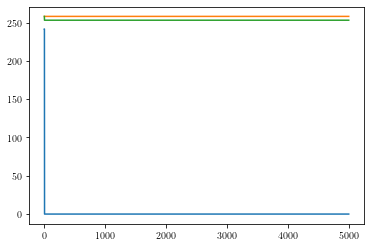

In [16]:
plt.plot(T_i)
plt.plot(T_w)
plt.plot(T_a)
plt.show()

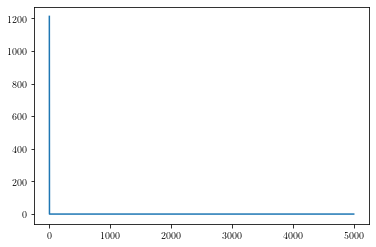

In [17]:
plt.plot(hc_i)
plt.show()

133.84505409311862